In [1]:
!pip install kagglehub  # Cài đặt KaggleHub
import kagglehub
import os


In [2]:
# Tải dataset về thư mục mặc định
path = kagglehub.dataset_download("vpapenko/nails-segmentation")

# In đường dẫn dataset
print("Dataset downloaded to:", path)


100%|██████████| 26.2M/26.2M [00:01<00:00, 14.8MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/vpapenko/nails-segmentation/versions/1


In [3]:
# In danh sách file/thư mục trong dataset
print(os.listdir(path))


['labels', 'images', 'nails_segmentation']


In [4]:
import os

image_dir = os.path.join(path, "images")
label_dir = os.path.join(path, "labels")
segmentation_dir = os.path.join(path, "nails_segmentation")

print("Images:", os.listdir(image_dir)[:5])   # Liệt kê 5 ảnh đầu tiên
print("Labels:", os.listdir(label_dir)[:5])   # Liệt kê 5 mask đầu tiên
print("Segmentation Files:", os.listdir(segmentation_dir)[:5])  # Kiểm tra thư mục segmentation


Images: ['d61a32a0-db67-11e8-9658-0242ac1c0002.jpg', 'd61d6de4-db67-11e8-9658-0242ac1c0002.jpg', 'd633f320-db67-11e8-9658-0242ac1c0002.jpg', '4252e46c-e40f-4543-91ab-031917d46c5c.jpg', '4c4a6402-e402-11e8-97db-0242ac1c0002.jpg']
Labels: ['d61a32a0-db67-11e8-9658-0242ac1c0002.jpg', 'd61d6de4-db67-11e8-9658-0242ac1c0002.jpg', 'd633f320-db67-11e8-9658-0242ac1c0002.jpg', '4252e46c-e40f-4543-91ab-031917d46c5c.jpg', '4c4a6402-e402-11e8-97db-0242ac1c0002.jpg']
Segmentation Files: ['labels', 'images']


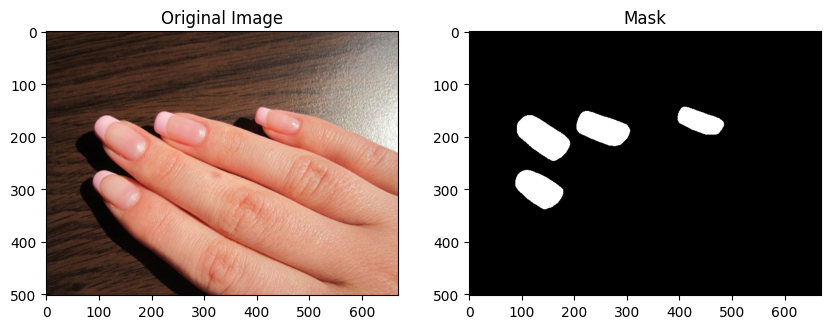

In [6]:
import matplotlib.pyplot as plt
import cv2

# Lấy đường dẫn một ảnh và mask
sample_image = os.path.join(image_dir, os.listdir(image_dir)[15])
sample_mask = os.path.join(label_dir, os.listdir(label_dir)[15])

# Đọc ảnh gốc
img = cv2.imread(sample_image)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Đọc mask (ảnh grayscale)
mask = cv2.imread(sample_mask, cv2.IMREAD_GRAYSCALE)

# Hiển thị ảnh và mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap="gray")
plt.title("Mask")

plt.show()


In [7]:
!pip install torch torchvision albumentations


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 52.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [8]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2


In [9]:
class NailDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_list = sorted(os.listdir(image_dir))
        self.mask_list = sorted(os.listdir(mask_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_list[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_list[idx])

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = (mask > 128).astype(np.float32)

        # Resize mask lên 512x512
        mask = cv2.resize(mask, (512, 512), interpolation=cv2.INTER_NEAREST)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image, mask = augmented["image"], augmented["mask"]

        return image, mask.unsqueeze(0)

# Thay đổi transform về 512x512
transform = A.Compose([
    A.Resize(512, 512),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])


In [10]:
from torch.utils.data import DataLoader

# Khởi tạo dataset
image_dir = os.path.join(path, "images")
mask_dir = os.path.join(path, "labels")

dataset = NailDataset(image_dir, mask_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)


In [11]:
transform = A.Compose([
    A.Resize(256, 256),  # Resize cả ảnh & mask về 256x256
    A.Normalize(mean=(0.5,), std=(0.5,)),  # Chuẩn hóa ảnh
    ToTensorV2()
], is_check_shapes=False)  # Tắt kiểm tra kích thước


In [12]:
dataset = NailDataset(image_dir, mask_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)


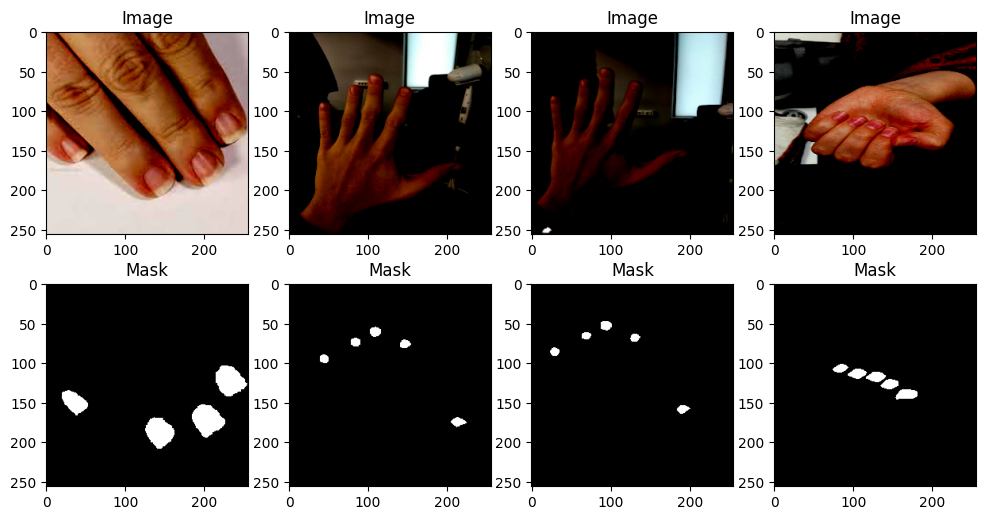

In [14]:
# Lấy một batch từ dataloader
images, masks = next(iter(dataloader))

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i in range(4):
    axes[0, i].imshow(images[i].permute(1, 2, 0))  # Chuyển tensor thành ảnh
    axes[0, i].set_title("Image")
    axes[1, i].imshow(masks[i][0], cmap="gray")
    axes[1, i].set_title("Mask")
plt.show()


In [16]:
import torch.nn as nn
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()

        # Encoder
        self.enc1 = nn.Sequential(nn.Conv2d(in_channels, 64, kernel_size=3, padding=1), nn.ReLU())
        self.enc2 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU())

        # Decoder
        self.dec1 = nn.Sequential(nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1), nn.ReLU())
        self.dec2 = nn.Sequential(nn.ConvTranspose2d(64, out_channels, kernel_size=3, padding=1), nn.Sigmoid())

    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.enc2(x1)

        x3 = self.dec1(x2)
        x4 = self.dec2(x3)

        return x4



# Khởi tạo mô hình
model = UNet().cuda()


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [ ]:
def iou_score(preds, masks, threshold=0.5):
    """Tính IoU giữa dự đoán và ground truth"""
    preds = (preds > threshold).float()
    intersection = (preds * masks).sum()
    union = preds.sum() + masks.sum() - intersection
    return (intersection + 1e-6) / (union + 1e-6)  # Tránh chia cho 0

def dice_score(preds, masks, threshold=0.5):
    """Tính Dice Score giữa dự đoán và ground truth"""
    preds = (preds > threshold).float()
    intersection = (preds * masks).sum()
    return (2. * intersection + 1e-6) / (preds.sum() + masks.sum() + 1e-6)

In [ ]:
import time

# Khai báo loss function & optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Biến lưu giá trị cuối cùng
final_loss = 0
final_iou = 0
final_dice = 0

# Huấn luyện mô hình
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    epoch_iou = 0
    epoch_dice = 0
    start_time = time.time()  # Bắt đầu đo thời gian

    for images, masks in dataloader:
        images, masks = images.cpu(), masks.cpu()

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_iou += iou_score(outputs, masks).item()
        epoch_dice += dice_score(outputs, masks).item()

    # Tính trung bình các chỉ số
    epoch_loss /= len(dataloader)
    epoch_iou /= len(dataloader)
    epoch_dice /= len(dataloader)

    # Cập nhật giá trị cuối cùng
    final_loss = epoch_loss
    final_iou = epoch_iou
    final_dice = epoch_dice

    # Tính thời gian chạy
    elapsed_time = time.time() - start_time

    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Loss: {epoch_loss:.4f} - "
          f"IoU: {epoch_iou:.4f} - "
          f"Dice: {epoch_dice:.4f} - "
          f"Time: {elapsed_time:.2f}s")

# In kết quả cuối cùng
print("\n🔥 Training Completed! 🔥")
print(f"Final Loss: {final_loss:.4f}")
print(f"Final IoU: {final_iou:.4f}")
print(f"Final Dice Score: {final_dice:.4f}")


Epoch [1/1000] - Loss: 0.2813 - IoU: 0.0031 - Dice: 0.0059 - Time: 96.72s


KeyboardInterrupt: 

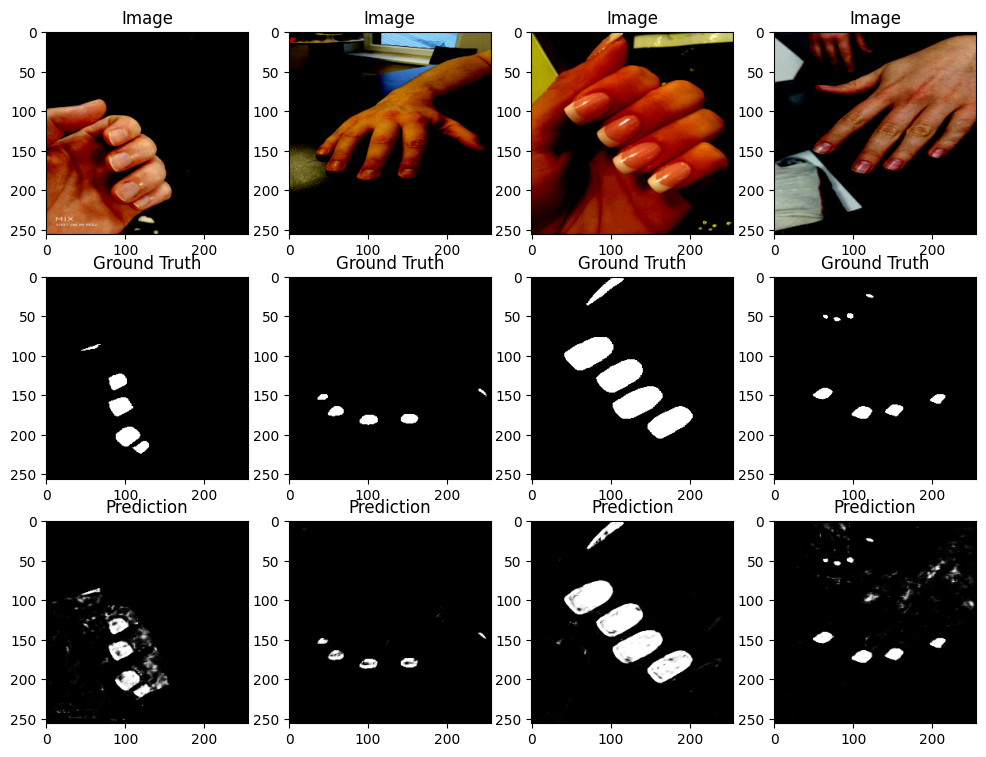

In [ ]:
# Lấy một batch ảnh để dự đoán
model.eval()
images, masks = next(iter(dataloader))
images = images.cuda()

with torch.no_grad():
    preds = model(images).cpu()

# Hiển thị ảnh, mask gốc & mask dự đoán
fig, axes = plt.subplots(3, 4, figsize=(12, 9))

for i in range(4):
    axes[0, i].imshow(images[i].cpu().permute(1, 2, 0))  # Ảnh gốc
    axes[0, i].set_title("Image")

    axes[1, i].imshow(masks[i][0].cpu(), cmap="gray")  # Mask gốc
    axes[1, i].set_title("Ground Truth")

    axes[2, i].imshow(preds[i][0], cmap="gray")  # Mask dự đoán
    axes[2, i].set_title("Prediction")

plt.show()


In [ ]:
torch.save(model.state_dict(), "nail_segmentation.pth")
print("Model saved successfully!")


Model saved successfully!


In [ ]:
# Khởi tạo lại kiến trúc model
model = UNet().cuda()

# Load trọng số đã lưu
model.load_state_dict(torch.load("nail_segmentation.pth"))
model.eval()  # Chuyển sang chế độ đánh giá
print("Model loaded successfully!")


Model loaded successfully!


<ipython-input-18-5bdfd856ed04>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("nail_segmentation.pth"))


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Accuracy: 0.994300548846905


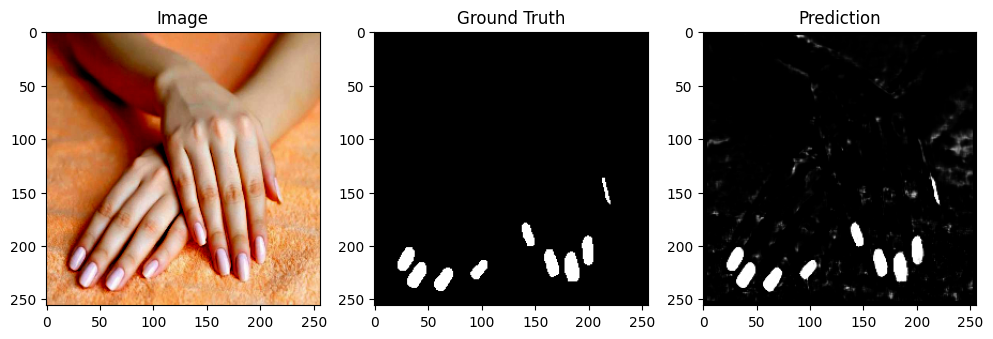

In [ ]:

# Assuming the dataset path is correct. Replace with the correct path if needed
dataset_path = "/content/drive/MyDrive/Colab Notebooks/Deeplearning/nail_segmentation"
image_dir = os.path.join(dataset_path, "images")
mask_dir = os.path.join(dataset_path, "labels")

# ... (rest of the code from the previous response, up to the model definition)

# ... (UNet model definition)


# Load the model (replace with your actual model loading code if different)
# model = UNet().cuda()
# model.load_state_dict(torch.load("nail_segmentation.pth")) # Assuming you saved your model
# model.eval()


transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
], is_check_shapes=False)

dataset = NailDataset(image_dir, mask_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=False)  # Important: shuffle=False for consistent evaluation

# Evaluation loop
model.eval()
correct_predictions = 0
total_samples = 0
with torch.no_grad():
    for images, masks in dataloader:
        images = images.cuda()
        masks = masks.cuda()
        preds = model(images)
        preds = (preds > 0.5).float()  # Apply threshold

        correct_predictions += (preds == masks).sum().item()
        total_samples += masks.numel()
    accuracy_val = correct_predictions / total_samples
    print(f"Accuracy: {accuracy_val}")

# Display a sample image
images, masks = next(iter(dataloader))
images = images.cuda()

with torch.no_grad():
    preds = model(images).cpu()


fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(images[2].cpu().permute(1, 2, 0))
axes[0].set_title("Image")

axes[1].imshow(masks[2][0].cpu(), cmap='gray')
axes[1].set_title("Ground Truth")

axes[2].imshow(preds[2][0], cmap='gray')
axes[2].set_title("Prediction")

plt.show()


In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

# Đường dẫn dataset
dataset_path = "/content/drive/MyDrive/Colab Notebooks/Deeplearning/nail_segmentation"
image_dir = os.path.join(dataset_path, "images")
mask_dir = os.path.join(dataset_path, "labels")

# Kiểm tra và in ra thông tin về images và labels
image_files = sorted(os.listdir(image_dir))
mask_files = sorted(os.listdir(mask_dir))

print(f"Total images found: {len(image_files)}")
print(f"Total labels found: {len(mask_files)}")

# In ra một số ví dụ
print("\nSample image files:")
for i in range(min(5, len(image_files))):
    print(f"  {image_files[i]}")

print("\nSample label files:")
for i in range(min(5, len(mask_files))):
    print(f"  {mask_files[i]}")

# Kiểm tra tên tệp có khớp nhau không
print("\nChecking file name matching...")
matching_count = 0
for img_file in image_files:
    img_name = os.path.splitext(img_file)[0]
    # Tìm label tương ứng (có thể có đuôi khác)
    matching_label = None
    for mask_file in mask_files:
        if os.path.splitext(mask_file)[0] == img_name:
            matching_label = mask_file
            matching_count += 1
            break

    if matching_label is None:
        print(f"Warning: No matching label found for {img_file}")

print(f"\nMatched pairs: {matching_count} / {len(image_files)}")

# Tạo dataset và dataloader
transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
], is_check_shapes=False)

test_dataset = NailDataset(image_dir, mask_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

print(f"\nDataset size: {len(test_dataset)}")
print(f"Number of batches in dataloader: {len(test_loader)}")

# Thêm vào đoạn đánh giá mô hình để in ra tiến trình
model.eval()
total_dice = 0.0
total_samples = 0
processed_images = 0

with torch.no_grad():
    for batch_idx, (images, masks) in enumerate(tqdm(test_loader, desc="Evaluating")):
        images = images.cuda()
        masks = masks.cuda()
        batch_size = images.size(0)
        processed_images += batch_size

        outputs = model(images)
        preds = (outputs > 0.5).float()

        # Tính Dice cho từng ảnh trong batch
        batch_dice = 0
        for i in range(batch_size):
            pred = preds[i]
            mask = masks[i]

            intersection = (pred * mask).sum().item()
            dice = (2. * intersection) / (pred.sum().item() + mask.sum().item() + 1e-6)
            batch_dice += dice
            total_dice += dice
            total_samples += 1

        # In thông tin mỗi 10 batch
        if (batch_idx + 1) % 10 == 0 or batch_idx == 0:
            print(f"Batch {batch_idx+1}/{len(test_loader)}, "
                  f"Processed images: {processed_images}/{len(test_dataset)}, "
                  f"Current batch avg dice: {batch_dice/batch_size:.4f}")

# Kiểm tra số lượng đã xử lý
print(f"\nTotal images processed: {processed_images}")
print(f"Total samples evaluated: {total_samples}")
assert total_samples == len(test_dataset), "Not all samples were evaluated!"

# Tính và in kết quả cuối cùng
avg_dice = total_dice / total_samples
print(f"\nEvaluation complete!")
print(f"Average Dice Coefficient: {avg_dice:.4f}")

Total images found: 52
Total labels found: 52

Sample image files:
  09aefeec-e05f-11e8-87a6-0242ac1c0002.jpg
  1eecab90-1a92-43a7-b952-0204384e1fae.jpg
  2C29D473-CCB4-458C-926B-99D0042161E6.jpg
  2c376c66-9823-4874-869e-1e7f5c54ec7b.jpg
  34404E67-4BB8-432E-863E-C1BEF5EB37E0.jpg

Sample label files:
  09aefeec-e05f-11e8-87a6-0242ac1c0002.jpg
  1eecab90-1a92-43a7-b952-0204384e1fae.jpg
  2C29D473-CCB4-458C-926B-99D0042161E6.jpg
  2c376c66-9823-4874-869e-1e7f5c54ec7b.jpg
  34404E67-4BB8-432E-863E-C1BEF5EB37E0.jpg

Checking file name matching...

Matched pairs: 52 / 52

Dataset size: 52
Number of batches in dataloader: 13


Evaluating:   8%|▊         | 1/13 [00:00<00:01,  7.51it/s]

Batch 1/13, Processed images: 4/52, Current batch avg dice: 0.9191


Evaluating:  85%|████████▍ | 11/13 [00:01<00:00,  7.33it/s]

Batch 10/13, Processed images: 40/52, Current batch avg dice: 0.9600


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  7.37it/s]


Total images processed: 52
Total samples evaluated: 52

Evaluation complete!
Average Dice Coefficient: 0.9239
